1- Tiền xử lý dữ liệu: Làm sạch dữ liệu, loại bỏ dư thừa, tách từ, stopword

2- Chia bộ dữ liệu thành Train/Test với tỉ lệ 0.7

3- Sử dụng WordEmbedding của thư viện Keras hỗ trợ cho dữ liệu đã xử lý ở trên, lưu kết quả wordembedding đó ra 1 file KerasWordEmbedding.txt

4- Sử dụng pretrained word embedding Fasttext (Facebook AI Research), lấy wordembedding của bộ dữ liệu trên ra 1 file FastTextWordEmbedding.txt

5- Sử dụng PhoBert cho bộ dữ liệu trên, lưu kết quả ra file PhoBertEmbedding.txt

6- Sử dụng 1 trong 3 kết quả ở các câu 2,3,4 là đầu vào cho các mô hình học sâu: MLP, RNN, LSTM, BiLSTM và CNN (các tham số của mô hình tự xây dựng) cho bài toán phân lớp ý kiến người dùng. In ra các tham số của mô hình huấn luyện

7- Đánh giá với 3 độ đo Accuracy, Confusion Matrix và F1-score và lưu kết quả ra 1 file

8- Với mô hình học sâu có kết quả cao nhất ở trên, sử dụng điểm Checkpoint để lưu kết quả huấn luyện với epoch cho kết quả cao nhất

9- Người dùng nhập vào một câu, sử dụng mô hình đã lưu ở trên dự đoán ý kiến của người dùng và in ra kết quả

In [1]:
!pip install pyvi
!pip install keras-self-attention

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18912 sha256=700a5c1ee916eb8ea620285035594818fa02d4cb256b37a7c6af62d16aa34d67
  Stored in directory: /root/.cache/pip/wheels/95/b1/a8/5ee00cc137940b2f6fa198212e8f45d813d0e0d9c3a04035a3
Successfully built keras-self-attention


In [2]:
# BATCH_SIZE = 100
SEED = 61

import re
import time
import string
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
# tf.keras.utils.set_random_seed(SEED)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Embedding,SimpleRNN, LSTM, Input, Flatten, Convolution1D, MaxPool1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow import keras

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from gensim.models.fasttext import FastText
from gensim.models import Word2Vec

import fasttext
import fasttext.util

import matplotlib.pyplot as plt

from pyvi import ViTokenizer

from tqdm import tqdm, notebook
from keras_self_attention import SeqSelfAttention


# import torch
# from transformers import AutoModel, AutoTokenizer

In [3]:
# colab_path = '/content/drive/MyDrive/DACNTT2/tasks/Text Sentiment Analysis/'

train_path = '../input/cleaned-sentiment-text/train.csv'
validation_path = '../input/cleaned-sentiment-text/validation.csv'
test_path = '../input/cleaned-sentiment-text/test.csv'

In [4]:
# train_path = '../input/text-sentiment-data/train.csv'
# validation_path = '../input/text-sentiment-data/validation.csv'
# test_path = '../input/text-sentiment-data/test.csv'

In [5]:
# data is already cleaned and splitted in 3 parts: train, validation and test
train_df = pd.read_csv(train_path, index_col=0)
validation_df = pd.read_csv(validation_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)
NUM_CLASSES = len(train_df['label'].unique())
index2class = {0:'neg', 1:'pos'}
class2index = {'neg': 0, 'pos':1}

print('Number of train data:', train_df.shape[0])
print('Number of validation data:', validation_df.shape[0])
print('Number of test data:', test_df.shape[0])
print('Number of classes:', NUM_CLASSES, '->', train_df['label'].unique())

train_df.head()

Number of train data: 29744
Number of validation data: 9920
Number of test data: 9920
Number of classes: 2 -> ['neg' 'pos']


,text,label
0,hôm_nay đi ngang quán quyết_định ghé mua quán ...,neg
1,đến_súp lơ trưa nắng gắt chủ_nhật hy_vọng súp ...,pos
2,hôm_qua xe đông khiếp lo bàn may_sao bàn lầu l...,pos
3,món ăn_ở ngon món bò kho chủ quán quán phục_vụ...,pos
4,đẹp trời đi mỳ mỳ vô_cùng mặn sợi bở bàn phục_...,neg


In [6]:
# X
train_data = train_df.iloc[:, 0].to_numpy()
validation_data = validation_df.iloc[:, 0].to_numpy()
test_data = test_df.iloc[:, 0].to_numpy()
whole_data = np.concatenate((train_data, validation_data, test_data), dtype=object)

In [7]:
# y
label_train = np.array([class2index[i] for i in train_df.iloc[:, 1]])
label_validation = np.array([class2index[i] for i in validation_df.iloc[:, 1]])
label_test = np.array([class2index[i] for i in test_df.iloc[:, 1]])
label_whole = np.concatenate((label_train, label_validation, label_test))

In [8]:
MAXLEN = max([len(x.split()) for x in whole_data]) # = 492
EMBEDDING_DIM = 100

# 6 - Sử dụng 1 trong 3 kết quả ở các câu 2,3,4 là đầu vào cho các mô hình học sâu: MLP, RNN, LSTM, BiLSTM và CNN (các tham số của mô hình tự xây dựng) cho bài toán phân lớp ý kiến người dùng. In ra các tham số của mô hình huấn luyện

In [9]:
# # load fasttext trained embedding layer weights to get feature vector accordingly
# ft_loaded = fasttext.load_model('data/embedding/fasttext/FastTextEmbeddingModel.bin')

In [10]:
# def fasttext_pretrained_embed_sentence(sent):
#     embedded_sent = np.zeros((EMBEDDING_DIM, ))
#     for i, word in enumerate(sent.split()):
#         embedded_sent += ft_loaded.get_word_vector(word)
#     return (embedded_sent/len(sent.split())).ravel().tolist()

# fasttext_pretrained_embed = np.frompyfunc(fasttext_pretrained_embed_sentence, 1, 1)

In [11]:
# X_train = np.array(fasttext_pretrained_embed(train_data).tolist())
# X_validation = np.array(fasttext_pretrained_embed(validation_data).tolist())
# X_test = np.array(fasttext_pretrained_embed(test_data).tolist())

In [12]:
# np.save('data/embedding/fasttext/X_train.npy', X_train)
# np.save('data/embedding/fasttext/X_validation.npy', X_validation)
# np.save('data/embedding/fasttext/X_test.npy', X_test)

In [13]:
# load saved embedded FastText features data
# data/embedding/fasttext/X_train.npy
# this is features from already cleaned text
X_train = np.load('../input/embeddings/X_train.npy', allow_pickle=True)
X_validation = np.load('../input/embeddings/X_validation.npy', allow_pickle=True)
X_test = np.load('../input/embeddings/X_test.npy', allow_pickle=True)

# MLP

In [14]:
early_stopping = EarlyStopping(patience=5, monitor="val_loss", verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, verbose=1)
# mlp.optimizer.get_config()
# adam initial learning rate = 0.001

In [15]:
mlp = Sequential()
mlp.add(Input(shape=(EMBEDDING_DIM,)))
mlp.add(Dense(200, activation='relu'))
mlp.add(Dense(100, activation='relu'))
mlp.add(Dense(20, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))

2022-06-10 13:33:27.080167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:33:27.232266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:33:27.233351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 13:33:27.234913: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 42,341
Trainable params: 42,341
Non-trainable params: 0
_________________________________________________________________
None


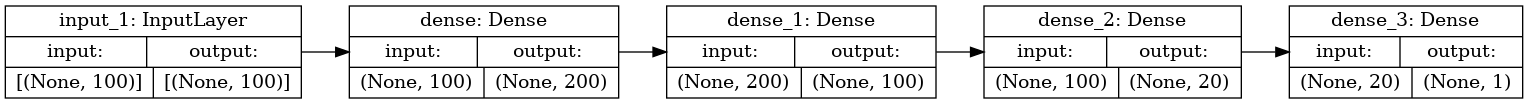

In [16]:
print(mlp.summary())
checkpoint_mlp = ModelCheckpoint('./model_checkpoint/mlp.h5', save_best_only=True, verbose=1)
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(mlp, rankdir='LR', show_shapes=True)

In [17]:
# mlp.fit(X_train, label_train, epochs=2, batch_size=100,
#         validation_data=(X_validation, label_validation), 
#         callbacks=[checkpoint_mlp, reduce_lr])

# RNN

In [18]:
rnn = Sequential()
rnn.add(Input(shape=(1, EMBEDDING_DIM)))
rnn.add(SimpleRNN(128, return_sequences=True))
rnn.add(SimpleRNN(128, return_sequences=False))
rnn.add(Dense(1, activation='sigmoid'))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 128)            29312     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 62,337
Trainable params: 62,337
Non-trainable params: 0
_________________________________________________________________
None


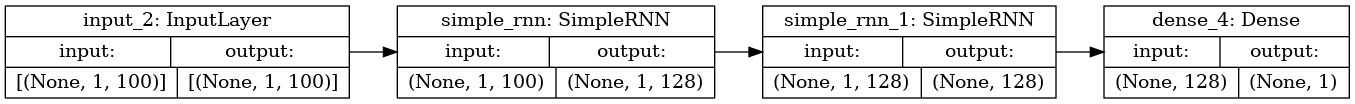

In [19]:
print(rnn.summary())
checkpoint_rnn = ModelCheckpoint('./model_checkpoint/rnn.h5', save_best_only=True, verbose=1)
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(rnn, rankdir='LR', show_shapes=True)

In [20]:
# rnn.fit(X_train.reshape(X_train.shape[0], -1, 100), label_train, epochs=100, batch_size=100,
#         validation_data=(X_validation.reshape(X_validation.shape[0], -1, 100), label_validation), 
#         callbacks=[checkpoint_rnn, reduce_lr])

# LSTM

In [21]:
lstm = Sequential()
lstm.add(Input(shape=(1, EMBEDDING_DIM)))
lstm.add(LSTM(256, return_sequences=True))
lstm.add(LSTM(128, return_sequences=True))
lstm.add(Dense(1, activation='sigmoid'))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 256)            365568    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
dense_5 (Dense)              (None, 1, 1)              129       
Total params: 562,817
Trainable params: 562,817
Non-trainable params: 0
_________________________________________________________________
None


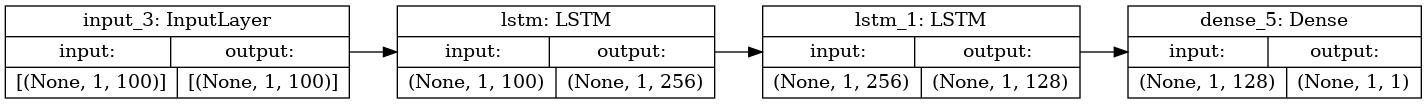

In [22]:
print(lstm.summary())
checkpoint_lstm = ModelCheckpoint('./model_checkpoint/lstm.h5', save_best_only=True, verbose=1)
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(lstm, rankdir='LR', show_shapes=True)

In [23]:
lstm.fit(X_train.reshape(X_train.shape[0], -1, 100), label_train, epochs=2, batch_size=100,
        validation_data=(X_validation.reshape(X_validation.shape[0], -1, 100), label_validation), 
        callbacks=[checkpoint_lstm, reduce_lr])

2022-06-10 13:33:33.203800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-06-10 13:33:37.667083: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


298/298 [==============================] - 9s 11ms/step - loss: 0.6147 - accuracy: 0.6529 - val_loss: 0.4853 - val_accuracy: 0.7750

Epoch 00001: val_loss improved from inf to 0.48528, saving model to ./model_checkpoint/lstm.h5
Epoch 2/2
298/298 [==============================] - 2s 8ms/step - loss: 0.4749 - accuracy: 0.7798 - val_loss: 0.4670 - val_accuracy: 0.7766

Epoch 00002: val_loss improved from 0.48528 to 0.46703, saving model to ./model_checkpoint/lstm.h5


# LSTM with Self-Attention

In [24]:
lstm1_input = Input(shape=(1, EMBEDDING_DIM))
self_attention = SeqSelfAttention() (lstm1_input)
x = LSTM(256, return_sequences=True) (self_attention)
x = LSTM(128, return_sequences=True) (x)
lstm1_output = Dense(1, activation='sigmoid') (x)
lstm1 = Model(lstm1_input, lstm1_output)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1, 100)]          0         
_________________________________________________________________
seq_self_attention (SeqSelfA (None, None, 100)         6465      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 256)         365568    
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         197120    
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           129       
Total params: 569,282
Trainable params: 569,282
Non-trainable params: 0
_________________________________________________________________
None


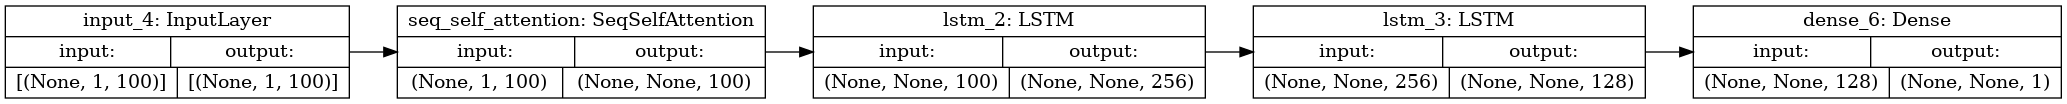

In [25]:
print(lstm1.summary())
checkpoint_lstm1 = ModelCheckpoint('./model_checkpoint/lstm1.h5', save_best_only=True, verbose=1)
lstm1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(lstm1, rankdir='LR', show_shapes=True)

In [26]:
lstm1.fit(X_train.reshape(X_train.shape[0], -1, 100), label_train, epochs=100, batch_size=100,
        validation_data=(X_validation.reshape(X_validation.shape[0], -1, 100), label_validation), 
        callbacks=[checkpoint_lstm1, reduce_lr])

Epoch 1/100
298/298 [==============================] - 8s 12ms/step - loss: 0.6147 - accuracy: 0.6527 - val_loss: 0.4852 - val_accuracy: 0.7745

Epoch 00001: val_loss improved from inf to 0.48521, saving model to ./model_checkpoint/lstm1.h5
Epoch 2/100
298/298 [==============================] - 3s 9ms/step - loss: 0.4747 - accuracy: 0.7802 - val_loss: 0.4665 - val_accuracy: 0.7771

Epoch 00002: val_loss improved from 0.48521 to 0.46647, saving model to ./model_checkpoint/lstm1.h5
Epoch 3/100
298/298 [==============================] - 2s 8ms/step - loss: 0.4606 - accuracy: 0.7833 - val_loss: 0.4706 - val_accuracy: 0.7790

Epoch 00003: val_loss did not improve from 0.46647
Epoch 4/100
298/298 [==============================] - 3s 9ms/step - loss: 0.4517 - accuracy: 0.7897 - val_loss: 0.4484 - val_accuracy: 0.7875

Epoch 00004: val_loss improved from 0.46647 to 0.44835, saving model to ./model_checkpoint/lstm1.h5
Epoch 5/100
298/298 [==============================] - 2s 8ms/step - loss: 0

In [27]:
# # Retrieve the config
# config = lstm1.get_config()

# # At loading time, register the custom objects with a `custom_object_scope`:
# custom_objects = {'seq_self_attention_1': self_attention}
# with keras.utils.custom_object_scope(custom_objects):
#     new_model = keras.Model.from_config(config)

# Bidirectional LSTM

In [28]:
bi_lstm = Sequential()
bi_lstm.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(1, EMBEDDING_DIM)))
bi_lstm.add(Bidirectional(LSTM(10)))
bi_lstm.add(Dense(1, activation='sigmoid'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 20)             8880      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                2480      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 11,381
Trainable params: 11,381
Non-trainable params: 0
_________________________________________________________________
None


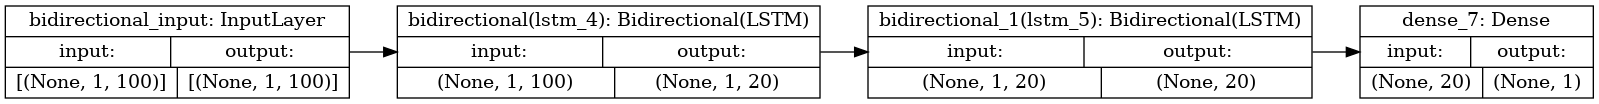

In [29]:
print(bi_lstm.summary())
checkpoint_bi_lstm = ModelCheckpoint('./model_checkpoint/bi_lstm.h5', save_best_only=True, verbose=1)
bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(bi_lstm, rankdir='LR', show_shapes=True)

In [30]:
# bi_lstm.fit(X_train.reshape(X_train.shape[0], -1, 100), label_train, epochs=100, batch_size=100,
#         validation_data=(X_validation.reshape(X_validation.shape[0], -1, 100), label_validation), 
#         callbacks=[checkpoint_bi_lstm, reduce_lr])

# CNN

In [31]:
'''Initializing the Convolutional Neural Network'''
cnn = Sequential()
cnn.add(Convolution1D(64, kernel_size=5, input_shape=(EMBEDDING_DIM, 1), activation='relu'))
cnn.add(MaxPool1D(pool_size=2))
cnn.add(Convolution1D(32, kernel_size=5, activation='relu'))
cnn.add(MaxPool1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 96, 64)            384       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 32)            10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 704)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                22560     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

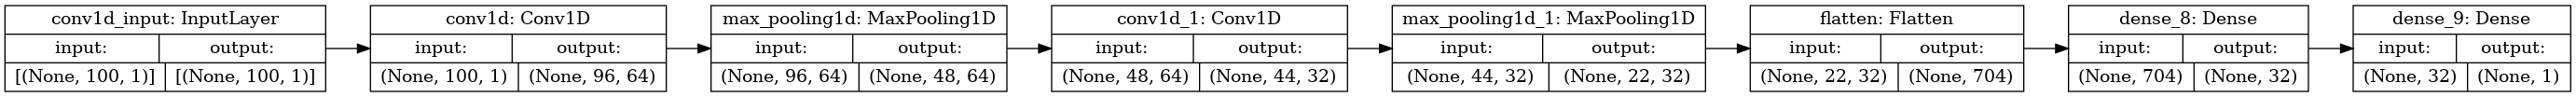

In [32]:
print(cnn.summary())
checkpoint_cnn = ModelCheckpoint('./model_checkpoint/cnn.h5', save_best_only=True, verbose=1)
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
plot_model(cnn, rankdir='LR', show_shapes=True)

In [33]:
# cnn.fit(X_train.reshape(X_train.shape[0], 100, -1), label_train, epochs=100, batch_size=100,
#         validation_data=(X_validation.reshape(X_validation.shape[0], 100, -1), label_validation), 
#         callbacks=[checkpoint_cnn, reduce_lr])

# 7 - Đánh giá với 3 độ đo Accuracy, Confusion Matrix và F1-score và lưu kết quả ra 1 file

# 8 - Với mô hình học sâu có kết quả cao nhất ở trên, sử dụng điểm Checkpoint để lưu kết quả huấn luyện với epoch cho kết quả cao nhất

In [34]:
# # load model with best saved checkpoint
# mlp = load_model('./model_checkpoint/mlp.h5')
# rnn = load_model('./model_checkpoint/rnn.h5')
# lstm = load_model('./model_checkpoint/lstm.h5')
# lstm1 = load_model('./model_checkpoint/lstm1.h5')
# bi_lstm = load_model('./model_checkpoint/bi_lstm.h5')
# cnn = load_model('./model_checkpoint/cnn.h5')

In [35]:
def convert_pred(pred):
    out = []
    for p in pred.flatten():
        if p >= 0.5:
            out.append(1)
        else:
            out.append(0)
    return out 

In [36]:
def evaluate(model, X_test):
    pred = convert_pred(model.predict(X_test))
    print('Accuracy:', accuracy_score(label_test, pred))
    print('F1-scrore:', f1_score(label_test, pred))
    cm = confusion_matrix(label_test, pred, labels=list(index2class.keys()))
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=list(index2class.keys()))
    cm_disp.plot()
    plt.show()

LSTM
Accuracy: 0.776108870967742
F1-scrore: 0.7580873543187016


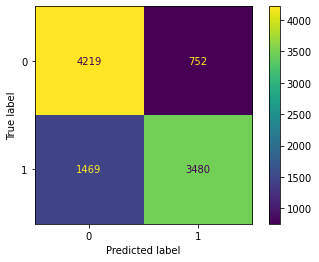

LSTM with Attention
Accuracy: 0.8015120967741935
F1-scrore: 0.802962073451416


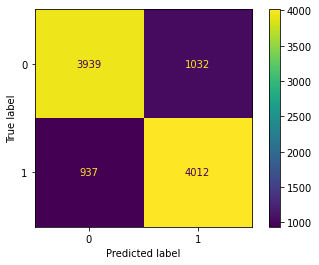

In [37]:
# print('MLP')
# evaluate(mlp, X_test)
# print('RNN')
# evaluate(rnn, X_test.reshape(X_test.shape[0], -1, 100))
print('LSTM')
evaluate(lstm, X_test.reshape(X_test.shape[0], -1, 100))
print('LSTM with Attention')
evaluate(lstm1, X_test.reshape(X_test.shape[0], -1, 100))
# print('Bi-LSTM')
# evaluate(bi_lstm, X_test.reshape(X_test.shape[0], -1, 100))
# print('CNN')
# evaluate(cnn, X_test.reshape(X_test.shape[0], 100, -1))

# 9 - Người dùng nhập vào một câu, sử dụng mô hình đã lưu ở trên dự đoán ý kiến của người dùng và in ra kết quả

In [38]:
# def predict_sentiment(sent):
#     # missing preprocess
#     embedded_sent = fasttext_pretrained_embed_sentence(sent)
#     pred = convert_pred(mlp.predict(np.array([fasttext_pretrained_embed_sentence(sent)])).ravel())
#     return index2class[pred[0]]

In [39]:
# print(predict_sentiment('quán này dở'))
# print(predict_sentiment('thức_ăn ngon'))